In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import timeit
%matplotlib inline

In [4]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
DATA_PATH = 'R:/Angela/fast_trips/'
APC = os.path.join(DATA_PATH, '2015SampleDataSpring_6day.csv')
ROUTE = os.path.join(DATA_PATH, 'MuniRouteTypes.csv')
VEHICLES = os.path.join(DATA_PATH, 'Vehicles.csv')
FLEET = os.path.join(DATA_PATH, 'Copy of Fleet.csv')

In [6]:
OUT_PATH = 'R:/Angela/fast_trips/Dwell_test_4_26'
TRAIN = os.path.join(OUT_PATH, 'df_train.csv')
TEST = os.path.join(OUT_PATH, 'df_test.csv')
#LM1_RESULTS = os.path.join(OUT_PATH, 'sklearn_results_VehcileDate.csv')
#LM1_CORR = os.path.join(OUT_PATH, 'corrlation_table_VehcileDate.csv')
LM2_RESULTS = os.path.join(OUT_PATH, 'sklearn_results_noVehicleDate.csv')
LM2_CORR = os.path.join(OUT_PATH, 'corrlation_table_noVehcileDate.csv')

# Input the same training (70%) and validating (30%) dataset, 
#from SF_Final_2.0_withVehicle model

In [7]:
df_train = pd.read_csv(TRAIN)
df_test = pd.read_csv(TEST)

# Build multi-linear regression model

Model independent variables: 

alighting: [OFF], [ON]

fleet info: [Floor]

Vehcile type: [three_doors]:articulated or not

route type: [Express], [OWL], [Rapid]

# Model 2 - without vehicle IDs 

In [9]:
X2_train = df_train[['ON','OFF','Floor','three_doors','Express','OWL','Rapid',
                     'on_threedoors','off_threedoors','on_floor','off_floor',
                     'on_express','off_express','on_rapid','off_rapid',
                     'on_owl','off_owl']]

X2_test = df_test[['ON','OFF','Floor','three_doors','Express','OWL','Rapid',
                   'on_threedoors','off_threedoors','on_floor','off_floor',
                   'on_express','off_express','on_rapid','off_rapid',
                   'on_owl','off_owl']]

y2_train = df_train.COMPUTE_DOORDWELL
y2_test = df_test.COMPUTE_DOORDWELL

In [11]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
pred2_train = lm2.predict(X2_train)
pred2_test = lm2.predict(X2_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

In [12]:
R2 = r2_score(y2_train, pred2_train) 
print 'R^2: ', R2
print 'Estimated intercept coefficient:', lm2.intercept_
print 'Number of coefficients:', len(lm2.coef_)

R^2:  0.252031973798
Estimated intercept coefficient: 10.4824607913
Number of coefficients: 17


In [13]:
# Construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)

In [14]:
sklearn_results2.to_csv(LM2_RESULTS)
print sklearn_results2

          features  estimatedCoefficients  pvalues     scores
0               ON                  2.388    0.000 199897.611
1              OFF                  1.686    0.000  96536.955
2            Floor                 -2.347    0.000   3646.381
3      three_doors                  1.246    0.000   1859.292
4          Express                 -0.963    0.000    428.394
5              OWL                 -0.599    0.000    340.279
6            Rapid                  2.362    0.000   2611.483
7    on_threedoors                 -0.540    0.000  91687.860
8   off_threedoors                 -0.505    0.000  51458.415
9         on_floor                 -0.325    0.000  32480.108
10       off_floor                 -0.314    0.000  13840.357
11      on_express                 -0.301    0.000  13547.188
12     off_express                 -0.347    0.000  14201.938
13        on_rapid                 -0.213    0.000  57697.480
14       off_rapid                 -0.316    0.000  35288.271
15      

# Correlation table 

find the top correlations in a correlation matrix with Pandas

In [15]:
c2 = X2_train.corr().abs()
s2 = c2.unstack()
so2 = s2.order(kind="quicksort")

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


In [16]:
so2.to_csv(LM2_CORR)
print 'Total number of correlation:', len(so2)
soo2 = so2.dropna()
soo2 = soo2[soo2 >= 0.500]
soo2 = soo2[soo2 != 1.0]
print 'Number of correlations larger than 0.5:', len(soo2)

Total number of correlation: 289
Number of correlations larger than 0.5: 24


In [17]:
soo2

Floor           on_floor         0.505
on_floor        Floor            0.505
Floor           off_floor        0.507
off_floor       Floor            0.507
Express         off_express      0.515
off_express     Express          0.515
three_doors     on_threedoors    0.542
on_threedoors   three_doors      0.542
three_doors     off_threedoors   0.557
off_threedoors  three_doors      0.557
Express         on_express       0.566
on_express      Express          0.566
ON              on_threedoors    0.570
on_threedoors   ON               0.570
OFF             off_threedoors   0.571
off_threedoors  OFF              0.571
OWL             off_owl          0.578
off_owl         OWL              0.578
on_rapid        Rapid            0.617
Rapid           on_rapid         0.617
                off_rapid        0.631
off_rapid       Rapid            0.631
on_owl          OWL              0.632
OWL             on_owl           0.632
dtype: float64

# Plot 1: residual

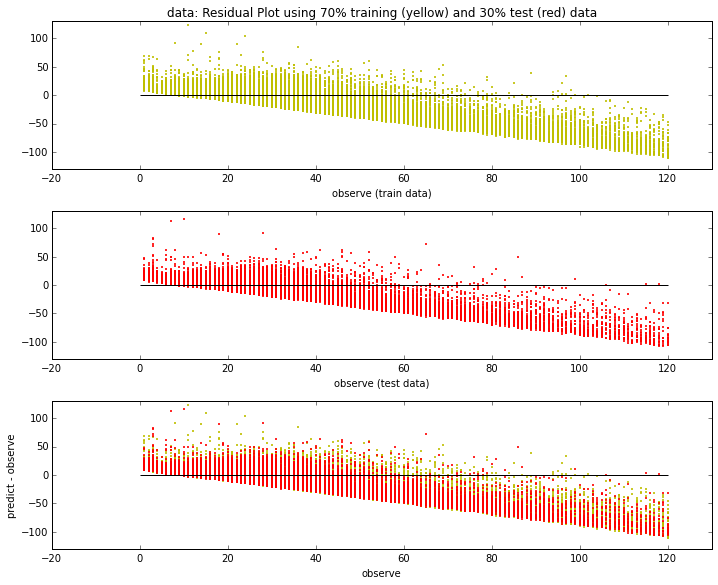

In [27]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')

plt.tight_layout()
plt.hlines(y=0, xmin=0, xmax=120)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.show()

# Plot 2: trend line

In [23]:
df_est = []
df_est = pd.DataFrame(lm2.predict(X2_test), index = X2_test.index, columns = ['Dwell_Time_Esti'])
test = pd.concat([X2_test, df_est], axis=1, join='inner')
test['on+off'] = test['ON']+test['OFF']
test.columns

Index([u'ON', u'OFF', u'Floor', u'three_doors', u'Express', u'OWL', u'Rapid',
       u'on_threedoors', u'off_threedoors', u'on_floor', u'off_floor',
       u'on_express', u'off_express', u'on_rapid', u'off_rapid', u'on_owl',
       u'off_owl', u'Dwell_Time_Esti', u'on+off'],
      dtype='object')

In [24]:
test_artic = test[test.three_doors == 1]
test_std = test[test.three_doors == 0]
test_low = test[test.Floor == 1]
test_exp = test[test.Express == 1]
test_rapid = test[test.Rapid == 1]
test_owl = test[test.OWL == 1]
test_local = test[(test.Express != 1) & (test.OWL != 1) & (test.Rapid != 1)]

19888 19888


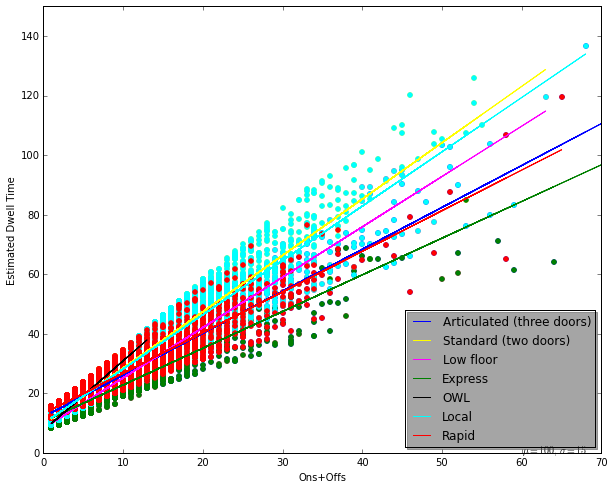

In [29]:
fig, ax = plt.subplots()

# Articulated bus
x1 = test_artic['on+off']
y1 = test_artic['Dwell_Time_Esti']
print len(x1), len(y1)
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Articulated (three doors)')

#Standard bus
x2 = test_std['on+off']
y2 = test_std['Dwell_Time_Esti']
ax.scatter(x2, y2, color = 'yellow')
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='yellow', label='Standard (two doors)')

#Low floor
x7 = test_low['on+off']
y7 = test_low['Dwell_Time_Esti']
ax.scatter(x7, y7, color = 'magenta')
fit = np.polyfit(x7, y7, deg=1)
ax.plot(x7, fit[0] * x7 + fit[1], color='magenta', label= 'Low floor')

#Express
x4 = test_exp['on+off']
y4 = test_exp['Dwell_Time_Esti']
ax.scatter(x4, y4, color = 'green')
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='green', label= 'Express')

#OWL
x5 = test_owl['on+off']
y5 = test_owl['Dwell_Time_Esti']
ax.scatter(x5, y5, color = '0.75')
fit = np.polyfit(x5, y5, deg=1)
ax.plot(x5, fit[0] * x5 + fit[1], color='black', label= 'OWL')

#Local
x6 = test_local['on+off']
y6 = test_local['Dwell_Time_Esti']
ax.scatter(x6, y6, color = 'cyan')
fit = np.polyfit(x6, y6, deg=1)
ax.plot(x6, fit[0] * x6 + fit[1], color='cyan', label= 'Local')

#Rapid
x8 = test_rapid['on+off']
y8 = test_rapid['Dwell_Time_Esti']
ax.scatter(x8, y8, color = 'red')
fit = np.polyfit(x8, y8, deg=1)
ax.plot(x8, fit[0] * x8 + fit[1], color='red', label= 'Rapid')

plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

#three doors trend is exactly as same as rapid ride bus... 

# Plot 3: Density scatter, observed V.S. y_predicted

# Training data

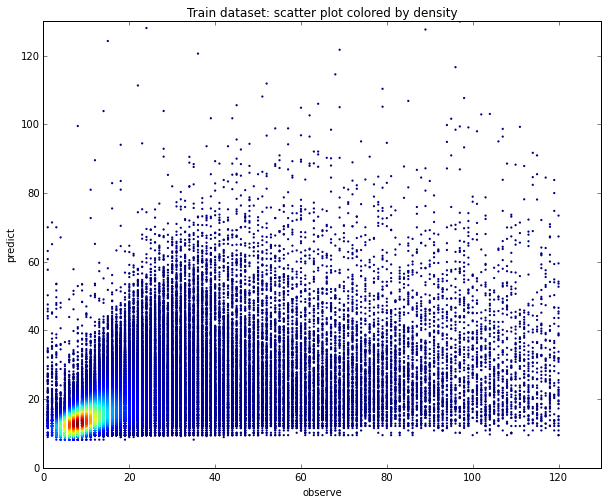

In [32]:
x2 = y2_train
y2 = lm2.predict(X2_train)

# Calculate the point density
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)

# Sort the points by density, so that the densest points are plotted last
idx = z2.argsort()

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

plt.axis([0, 130, 0, 130])
plt.title('Train dataset: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.show()

# Test data

z: 305.005552187
sort data: 0.00655069879235


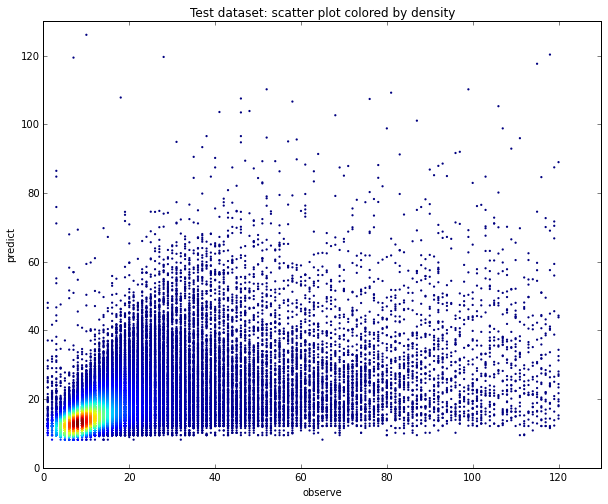

In [30]:
x2 = y2_test
y2 = lm2.predict(X2_test)

# Calculate the point density
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)

# Sort the points by density, so that the densest points are plotted last
idx = z2.argsort()

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

plt.axis([0, 130, 0, 130])
plt.title('Test dataset: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.show()


In [57]:
print 'end'

end
